In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.constants import N_A
import pints
from scipy.integrate import solve_ivp
import pints.plot
import pathlib
from lmfit import Model
sns.set_context('talk')

In [67]:
Target_cell_number = 5e4
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
tumour_cell_radius = 8e-6
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'noise1', 'noise2']
t_end = 60*60*1
t = np.geomspace(1e-10, t_end, 50)
rtot = 1.8e6
tspan = [1e-10, t_end]

kons = [2.6e5, 3.1e4, 3.8e5, 3.3e5, 3e5]
KDs = [1.8e-9, 0.8e-9, 22e-9, 293e-9, 9e-9]

In [68]:
def model_eqns(t, z, kon, KD, k2, rtot, Ainit):
    Atot = Ainit*sigma
    k1 = kon/sigma
    A0 = Atot - z[0] - z[1]
    r = rtot - z[0] - 2*z[1]

    dA1 = 2*k1*r*A0 - (KD*kon)*z[0] - k2*r*z[0] + 2*(KD*kon)*z[1]
    dA2 = k2*z[0]*r - 2*(KD*kon)*z[1]

    return [dA1, dA2]


def solve_model_individual(kon, KD, k2, rtot, A0s):
    solution = np.zeros_like(A0s)
    z0 = [0, 0]
    for i, Ainit in enumerate(A0s):
        z = solve_ivp(model_eqns, tspan, z0, method='Radau', t_eval=t, args=(kon, KD, k2, rtot, Ainit))
        A1 = z.y[0]
        A2 = z.y[1]
        bound_ab = A1[-1] + A2[-1]
        solution[i] = bound_ab
    
    return solution

def simulate_model(A0s, parameters):

    kon1 = parameters[0]
    kon1 = 10**kon1
    KD1 = parameters[1]
    KD1 = 10**KD1
    kon2 = parameters[2]
    kon2 = 10**kon2
    KD2 = parameters[3]
    KD2 = 10**KD2
    kon3 = parameters[4]
    kon3 = 10**kon3
    KD3 = parameters[5]
    KD3 = 10**KD3
    kon4 = parameters[6]
    kon4 = 10**kon4
    KD4 = parameters[7]
    KD4 = 10**KD4
    k2 = parameters[8]
    k2 = 10**k2
    C = parameters[9]
    C=10**C
    b = parameters[10]
    b = 10**b
    solution = np.zeros((len(A0s)))
    kon_params = [kon1, kon2, kon3, kon4]
    KD_params = [KD1, KD2, KD3, KD4]

    for i in range(len(kon_params)):
        solution[:, i] = (solve_model_individual(kon_params[i], KD_params[i], k2, rtot, A0s))

    return np.log10((C*solution + b)/rtot)

def simulate_model1(A0s, parameters):

    k2 = parameters[0]
    k2 = 10**k2
    C = parameters[1]
    C=10**C
    b = parameters[2]
    b = 10**b
    solution = np.zeros((len(A0s), len(kons)))
    for i in range(len(kons)):
        solution[:, i] = (solve_model_individual(kons[i], KDs[i], k2, rtot, A0s))

    return (C*solution + b)/rtot

def simulate_model_ls(A0s, k2, C, b):
    k2 = 10**k2
    C = 10**C
    b = 10**b
    solutions = []
    for i in range(len(kons)):
        solution1 = np.zeros((len(A0s)))
        solution1[:] = (solve_model_individual(kons[i], KDs[i], k2, rtot, A0s))
        solutions.append((C*solution1 +b)/rtot)
    
    solution = np.asarray(np.concatenate(([solutions[i] for i in range(len(solutions))])))
    return solution

In [69]:
data1 = []

from pathlib import Path
pathlist = Path('/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_her2_binding/BT474').glob('**/*.csv')

for path in pathlist:
    print(path)
    df = pd.read_csv(str(path))
    conc = df['Concentration'].values
    conc = conc*1e-9
    vals = df['MFI'].values
    data1.append(vals)

data = np.stack((data1), axis=1)
data2 = np.asarray(np.concatenate(([data1[i] for i in range(len(data1))])))
A0s = conc
print(data2)

/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_her2_binding/BT474/H3B1.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_her2_binding/BT474/B1D2.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_her2_binding/BT474/C65.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_her2_binding/BT474/G98A.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_her2_binding/BT474/ML3-9.csv


In [70]:
ls_model = Model(simulate_model_ls)
ls_model.set_param_hint('k2', min = 12, max = -3)
ls_model.set_param_hint('C', min = -2, max = 3)
ls_model.set_param_hint('b', min = -6, max = 10)


parameters = ls_model.make_params(k2=-4, C=0.1, b=2)

result = ls_model.fit(data2, parameters, A0s=A0s)

In [71]:
print(result.fit_report())

[[Model]]
    Model(simulate_model_ls)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 40
    # variables        = 3
    chi-square         = 90.7319897
    reduced chi-square = 2.45221594
    Akaike info crit   = 38.7612215
    Bayesian info crit = 43.8278599
    R-squared          = 0.65667016
[[Variables]]
    k2: -2.99946385 +/- 7.98639318 (266.26%) (init = 12)
    C:   0.93906628 +/- 0.05923022 (6.31%) (init = 0.1)
    b:  -5.59622300 +/- 1.2935e+11 (2311375838993.18%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, b)  = -0.7871
    C(k2, C) = +0.1787


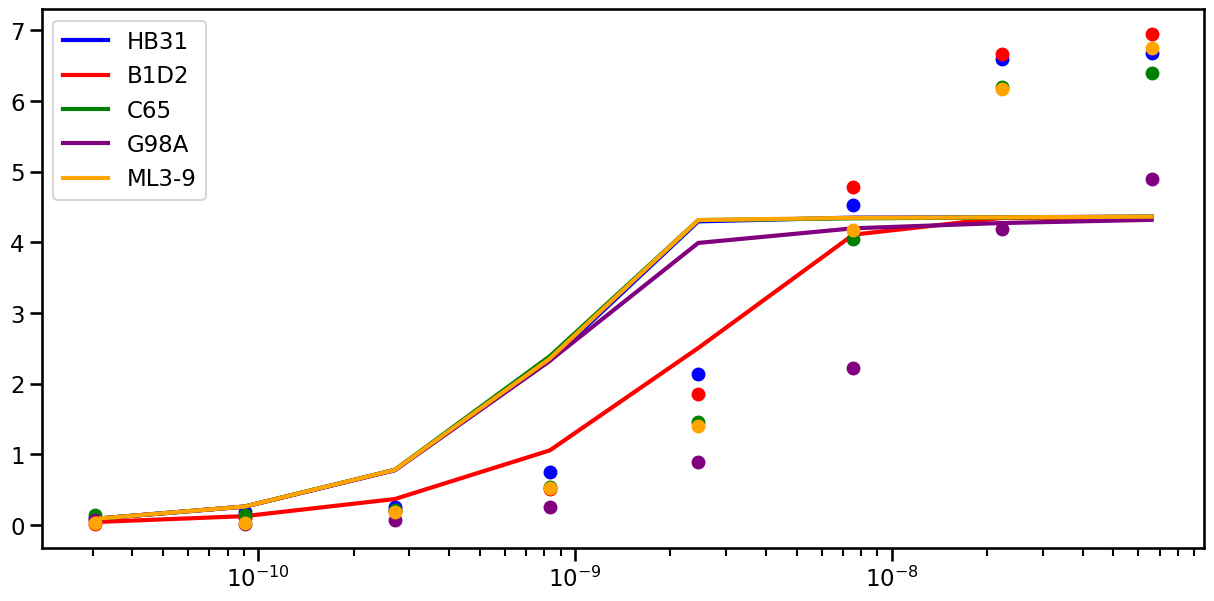

In [72]:
plt.figure(figsize=(15, 7))
param_results = result.best_values

colors = ['blue', 'red', 'green', 'purple', 'orange']
labels = ['HB31', 'B1D2', 'C65', 'G98A', 'ML3-9']
vals = simulate_model_ls(A0s, param_results['k2'], param_results['C'], param_results['b'])
for i in range(len(kons)):
    plt.plot(A0s, data[:, i], 'o', c=colors[i])
    plt.plot(conc, vals[i*8: 8*(i+1)], label=labels[i], lw=3, c=colors[i])
plt.legend()
plt.xscale('log')
plt.show()

In [73]:
class model(pints.ForwardModel):

    def n_outputs(self):
         return 4
    
    def n_parameters(self):
        return 3
    
    def simulate(self, parameters, A0s):
        return np.log10(simulate_model1(A0s, parameters))

In [74]:
mod = model()
problem = pints.MultiOutputProblem(mod, conc, data)
log_likelihood = pints.GaussianLogLikelihood(problem)
parameters = [-5,  0.1, 2, 0.01, 0.01, 0.01, 0.01]
log_prior = pints.UniformLogPrior(
    [-11, -2, 0, 0.0001, 0.0001, 0.0001, 0.0001],
    [-1, 1, 4, 0.5, 0.5, 0.5, 0.5]
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

ValueError: Values array must have shape `(n_times, n_outputs)`.

In [ ]:
xs = [
    np.array(parameters) * 0.9,
    np.array(parameters) * 0.95,
    np.array(parameters) * 1.05,
    np.array(parameters) * 1.11 
]

In [ ]:
mcmc = pints.MCMCController(log_posterior, 4, xs)
mcmc.set_max_iterations(15000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.4
1     8      0         0         0         0          0:00.4
2     12     0         0         0         0          0:00.5
3     16     0         0         0.25      0          0:00.7
20    84     0.381     0.0476    0.238     0.286      0:05.5
40    164    0.317     0.122     0.244     0.366      0:13.7
60    244    0.426     0.18      0.377     0.328      0:20.8
80    324    0.407     0.259     0.42      0.407      0:26.7
100   404    0.416     0.317     0.396     0.465      0:32.3
120   484    0.397     0.338843  0.438     0.463      0:37.5
140   564    0.411     0.348     0.426     0.475      0:42.7
160   644    0.422     0.36      0.416     0.466      0:47.9
180   724    0.431     0.392     0.441989  0.475      0:53.0
Initial phase completed.
200   804    0.433     0.

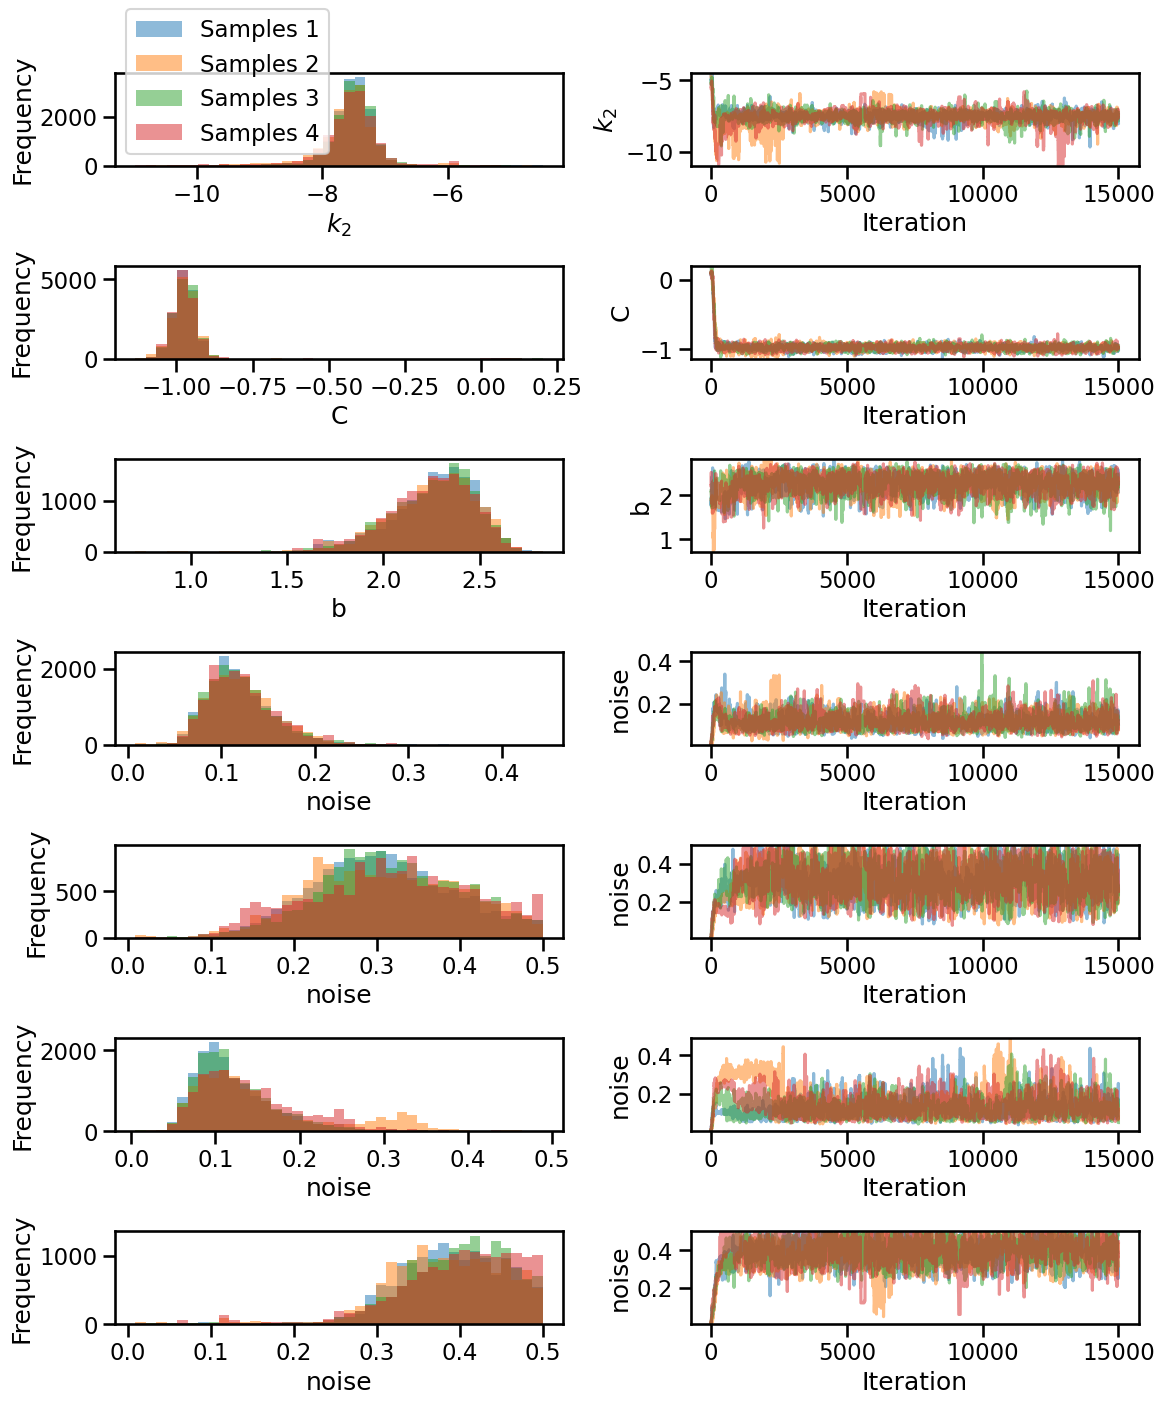

In [ ]:
import pints.plot
parameter_names=[ r'$k_2$', 'C', 'b', 'noise', 'noise', 'noise', 'noise']
pints.plot.trace(chains, parameter_names=parameter_names)
plt.show()

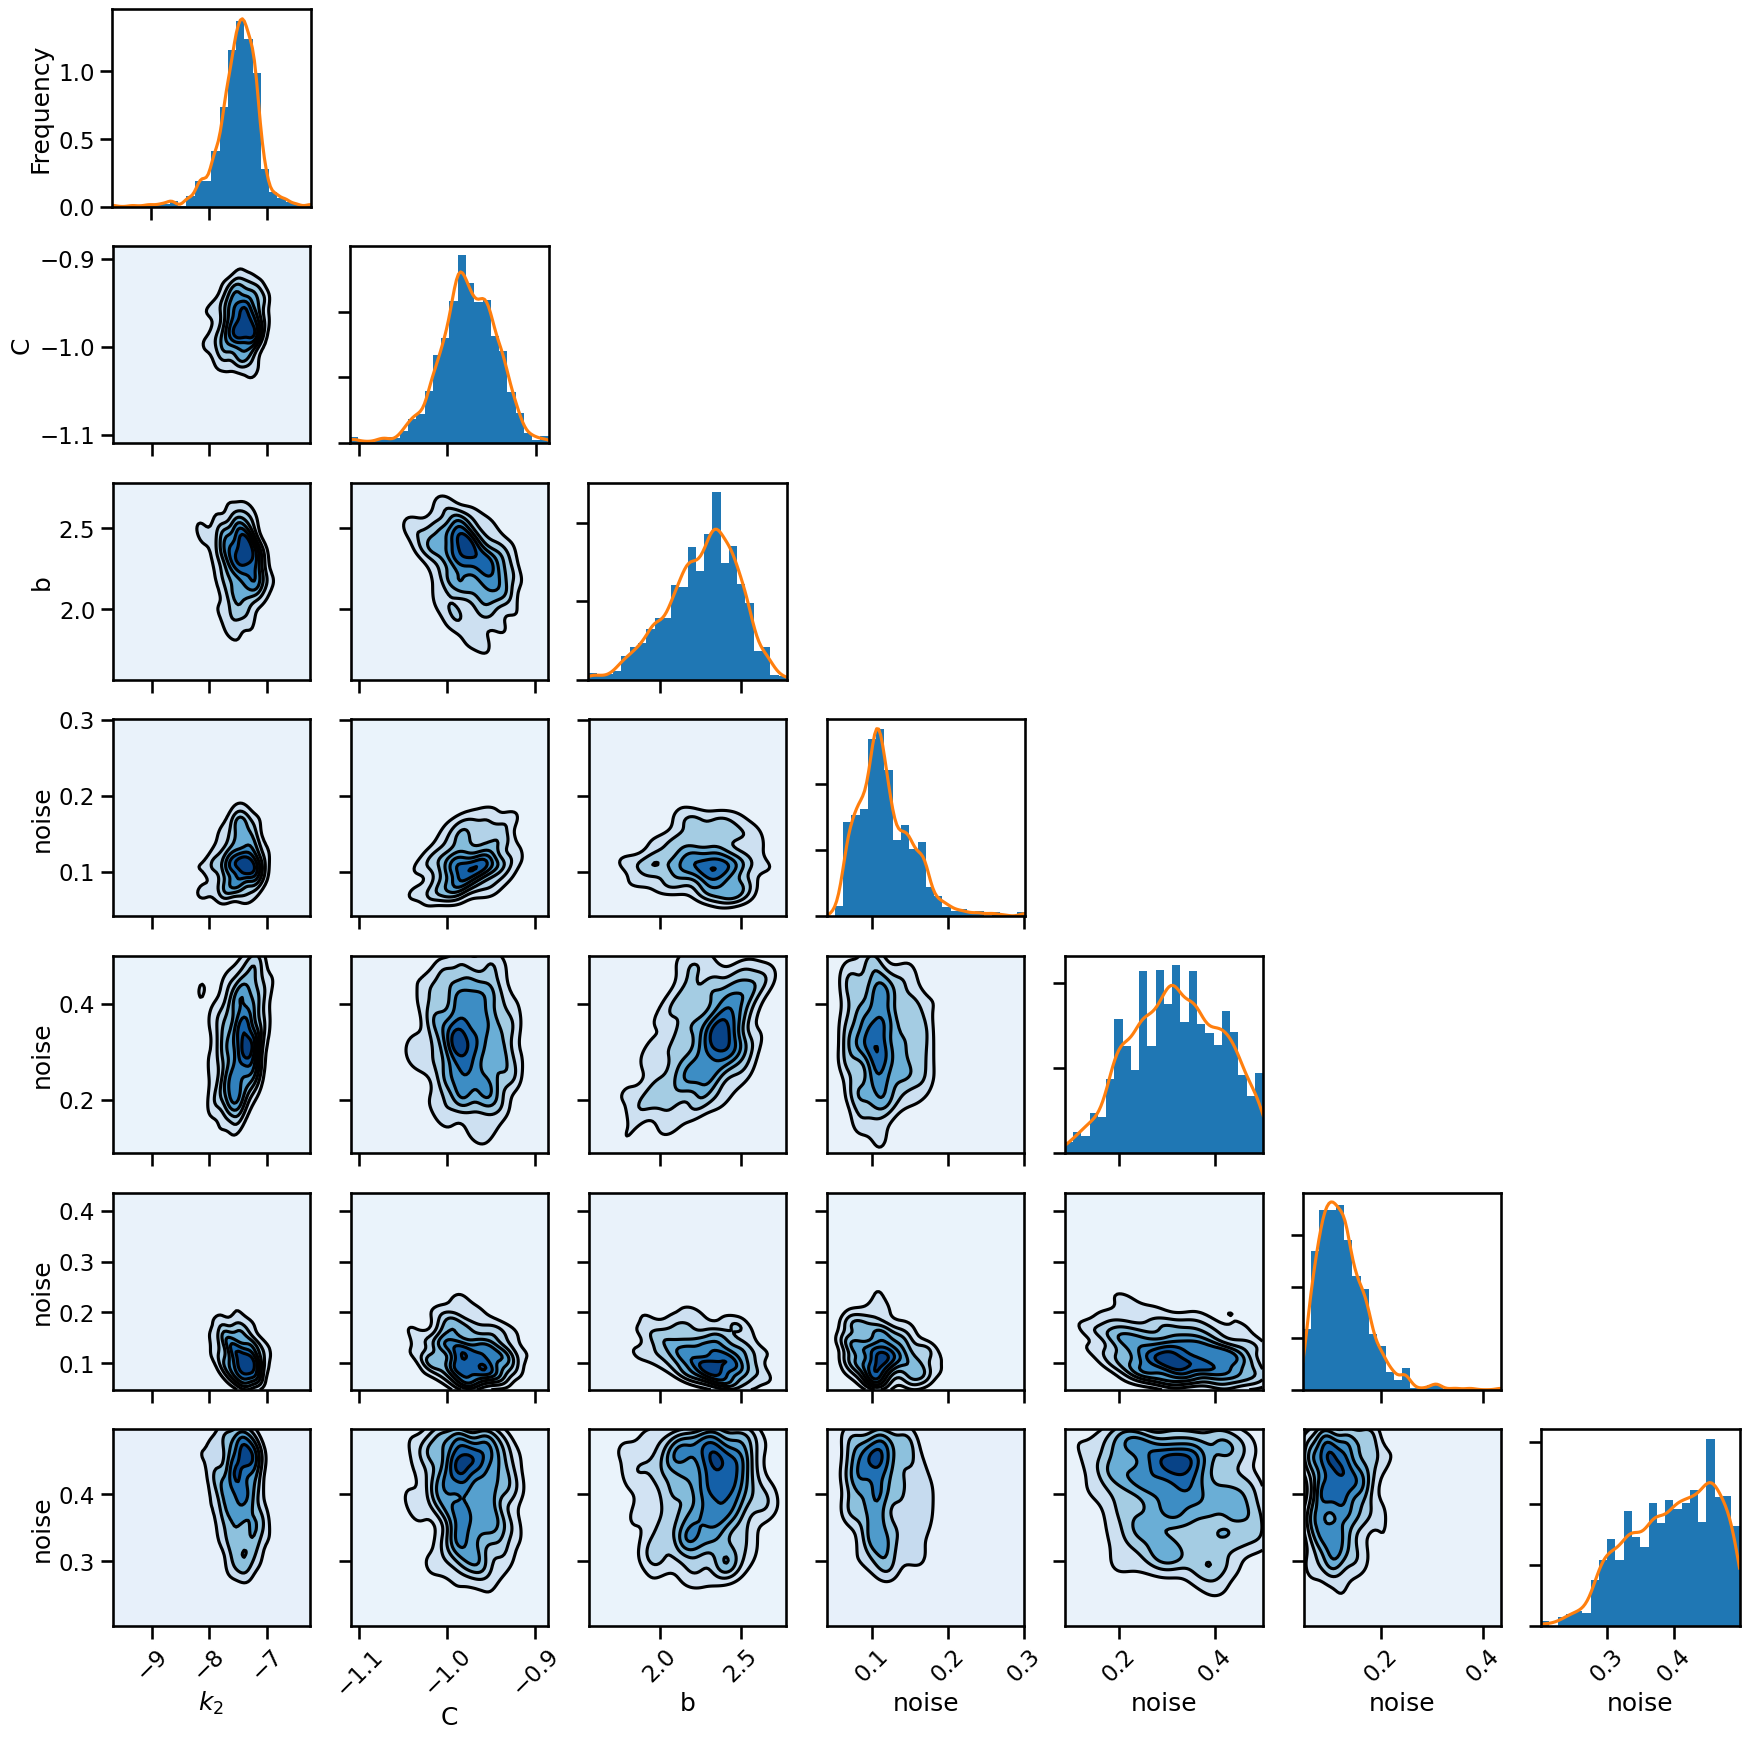

In [ ]:
chain = chains[0]
chain = chain[12000:]
chains1 = chains[:, 12000 :]
pints.plot.pairwise(chain, kde=True,  parameter_names=parameter_names)
plt.show()

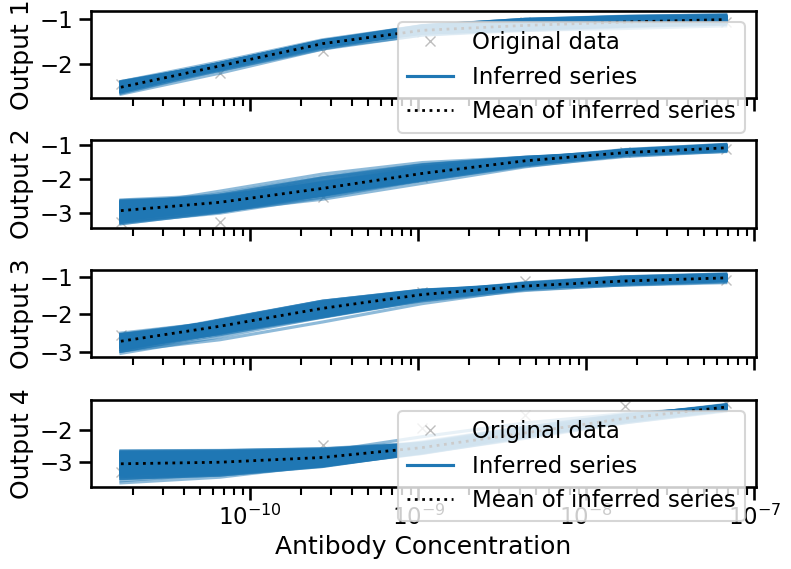

In [ ]:
fig, axes = pints.plot.series(chains1[0], problem)

plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()

In [ ]:
results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=parameter_names)
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
$k_2$    -7.59   0.49    -8.77   -7.75  -7.51  -7.33  -6.94    1.06    291.82  0.09
C        -0.98   0.04    -1.05   -1.00  -0.98  -0.95  -0.91    1.01    433.09  0.13
b        2.25    0.21    1.80    2.11   2.28   2.42   2.60     1.01    348.61  0.10
noise    0.12    0.04    0.06    0.09   0.11   0.15   0.22     1.01    333.02  0.10
noise    0.31    0.09    0.13    0.24   0.31   0.39   0.48     1.01    344.97  0.10
noise    0.14    0.06    0.06    0.09   0.12   0.16   0.29     1.04    320.29  0.10
noise    0.40    0.06    0.28    0.36   0.41   0.45   0.49     1.03    318.76  0.09


In [ ]:
results_list = results._summary_list
results_dic = {}
means =[]
stds = []
l_perc = []
h_perc = []
rhats = []
parameter_names=[r'$k_2$', 'C','b']
for i, param in enumerate(parameter_names):
    holder = results_list[i]
    means.append(holder[1])
    stds.append(holder[2])
    l_perc.append(holder[3])
    h_perc.append(holder[7])
    rhats.append(holder[8])

results_dic['parameter'] = parameter_names
results_dic['mean'] = means
results_dic['std'] = stds
results_dic['2.5%'] = l_perc
results_dic['97.5%'] = h_perc
results_dic['rhat'] = rhats

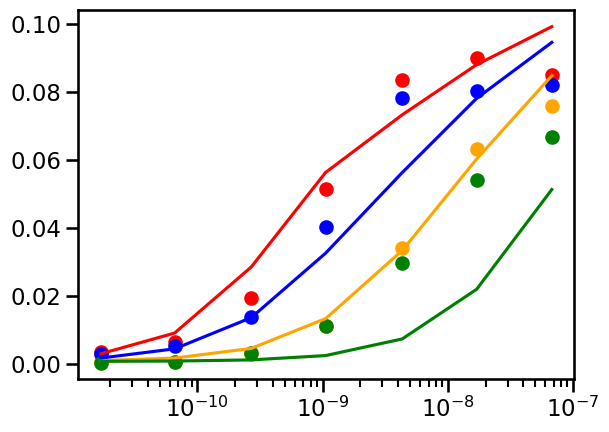

In [ ]:
#parameters = [-6.5, -0.96, 2.06]
parameters = results_dic['mean']
sim = simulate_model1(conc, parameters=parameters)
colors=['red', 'orange', 'blue', 'green']
for i in range(len(kons)):
    plt.semilogx(conc, sim[:, i], label='fit', c=colors[i])
    plt.scatter(conc, 10**data[:, i], label='data', c=colors[i])